# Dogs vs Cats
**Autor: Albert Heckmann**

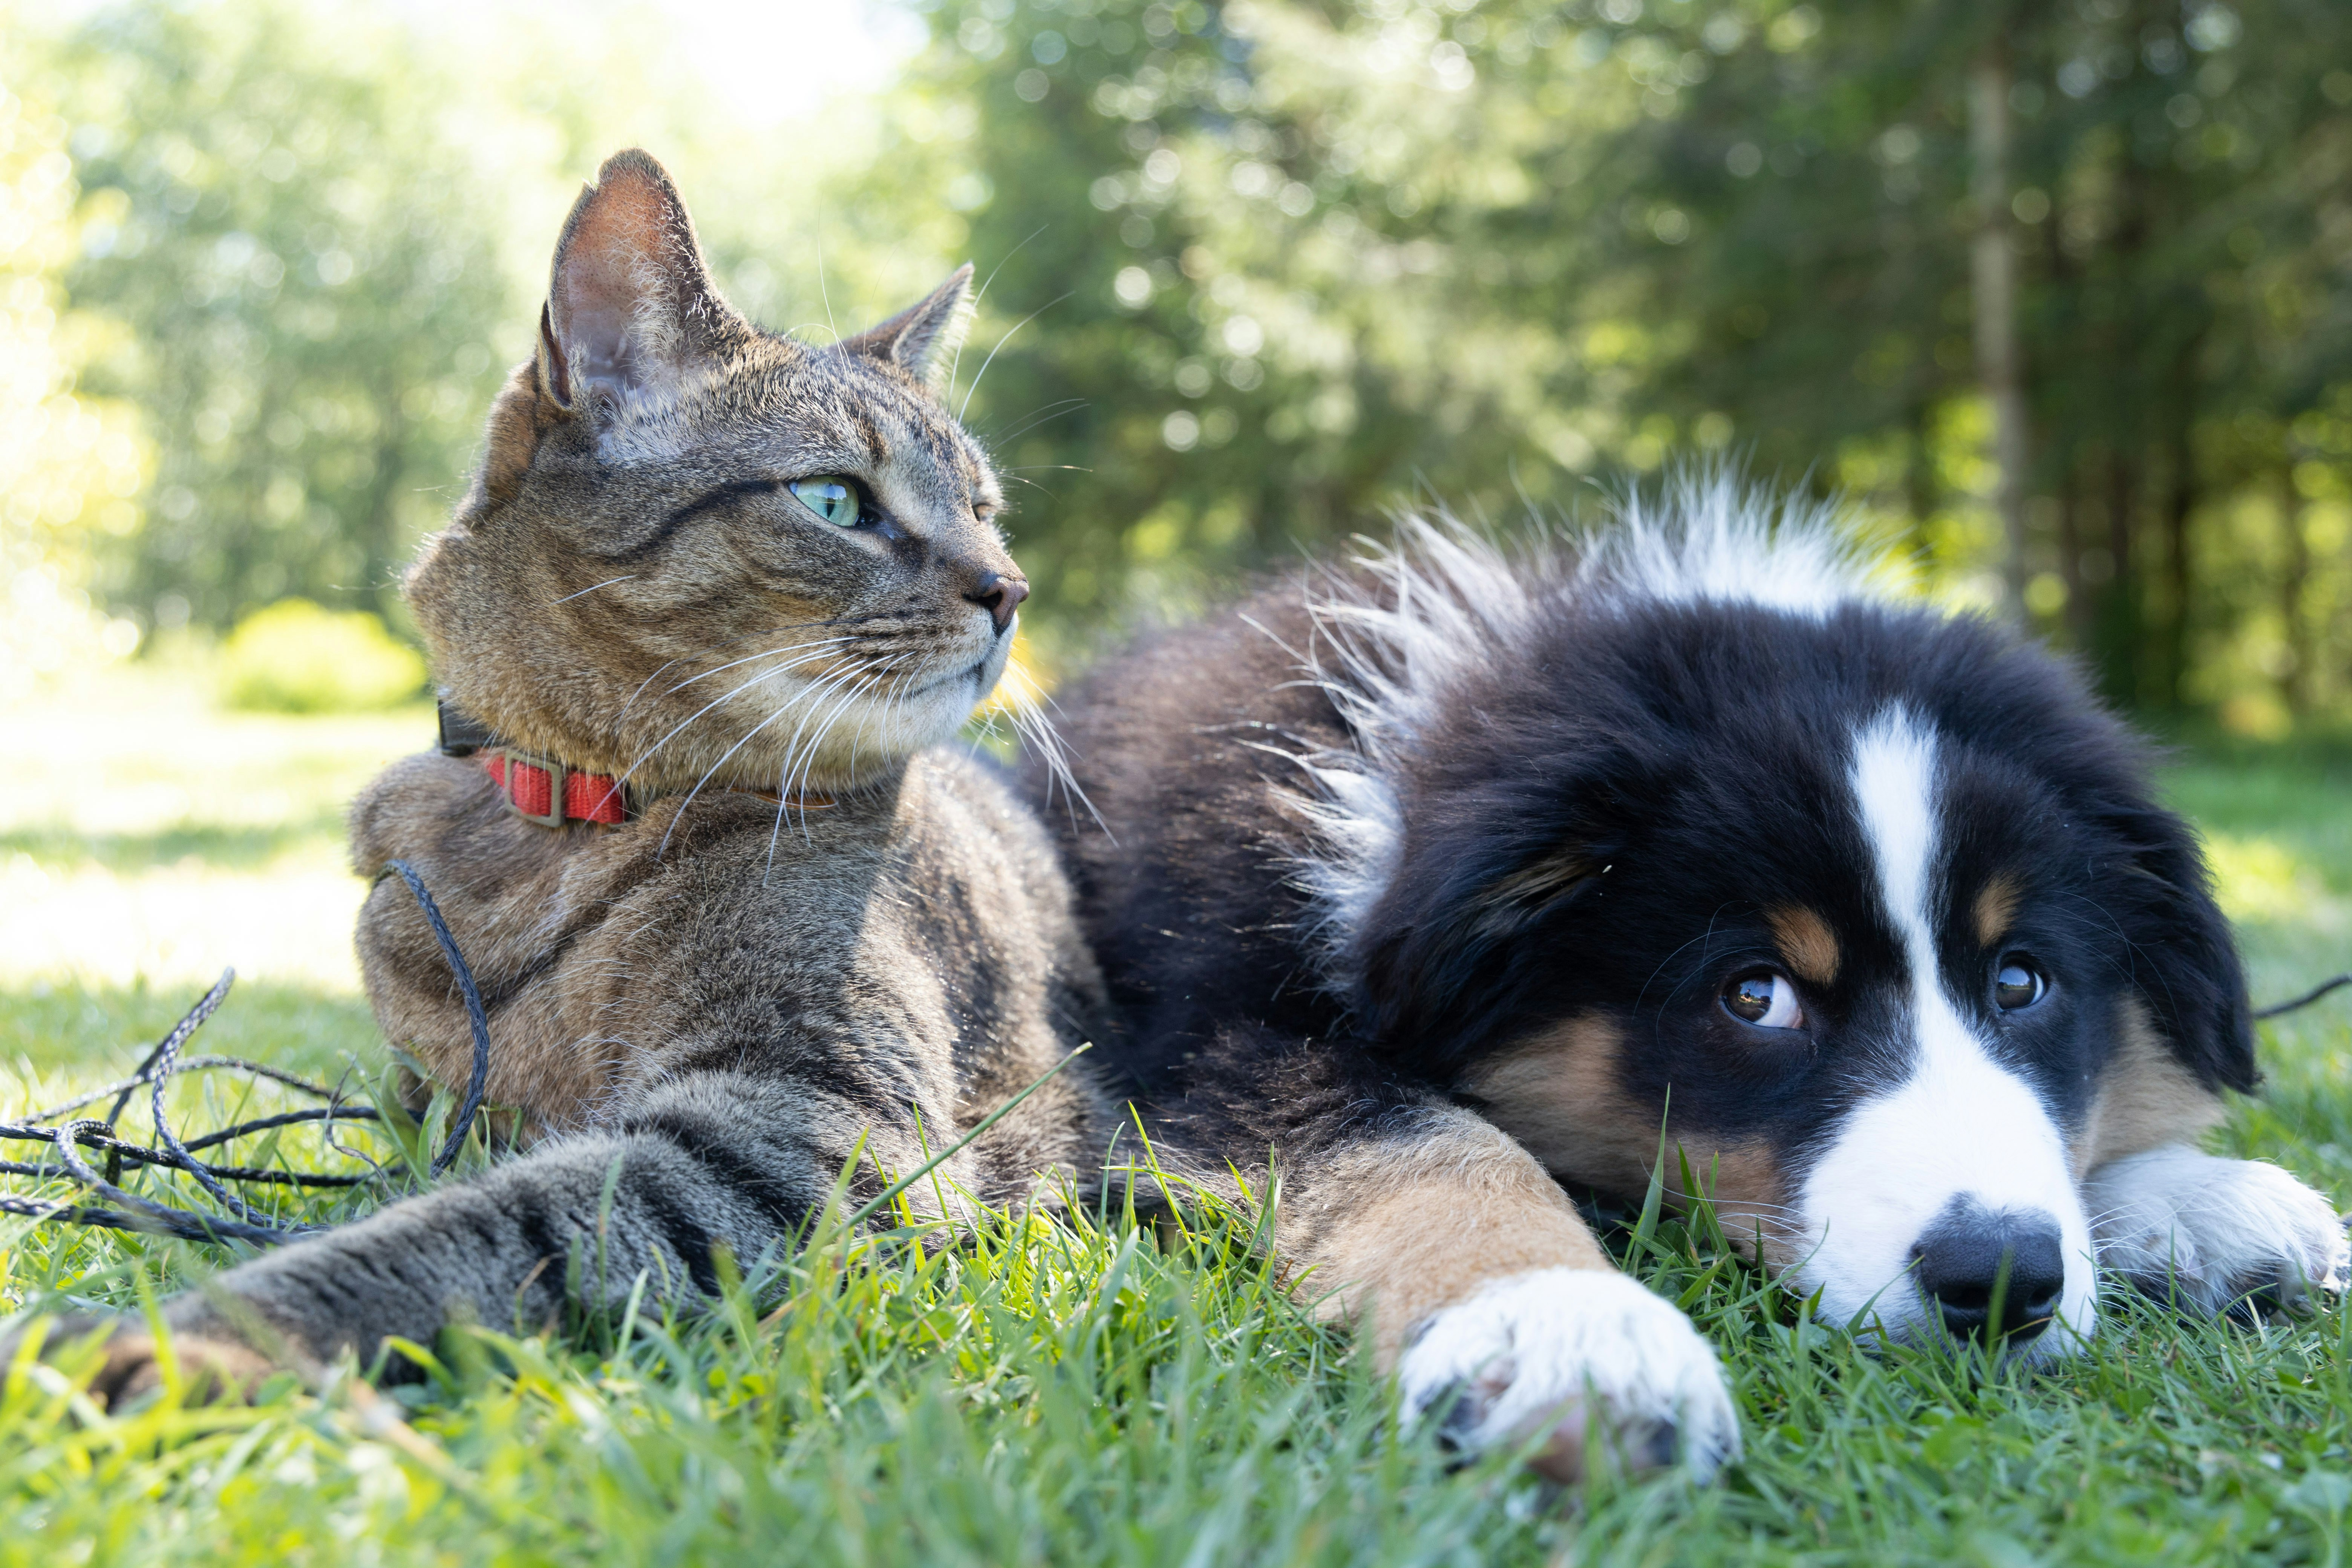
*Foto von Andrew S auf Unsplash*: [link](https://unsplash.com/de/fotos/ein-hund-und-eine-katze-liegen-im-gras-ouo1hbizWwo)

## Einführung
### Hund!...oder Katze?...oder doch Hund?
Für uns Menschen ist es relativ einfach zu erkennen, ob es sich um einen Hund oder eine Katze handelt.\
Unser Gehirn hat Millionen Jahre Evolution hinter sich – wir sind darauf trainiert, Tiere zu erkennen.\
Bei Computern ist das anders. Sie sehen nur eine Zahlenmatrix mit zu vielen Pixeln und entsprechenden RGB-Werten (Rot, Grün, Blau).

Folglich:\
-> Wir sehen einen flauschigen Hund.\
-> Die Maschine eine gefühlt endlose Zahlenschlange.

Es ist aber wichtig, dass Computer heutzutage Bilder erkennen z.B.:
* In der Medizin um frühzeitig Krankheiten zu erkennen und Diagnosen zu erstellen.
* In der Forschung um mikroskopischen Aufnahmen zu analysieren.
* In der Sicherheit um verdächtige Personen oder Verhalten zu erkennen.
* In der Industrie bei der Fertigung um Fehler in der Produktion zu erkennen.  

## Aufgabenstellung
Damit die Maschinen solche Unterschiede erkennen können, soll hier ein Machine-Learning-Modell erstellt und trainiert werden.\
Hierzu wurde ein Datensatz aus [(Kaggle)](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset?select=kagglecatsanddogs_3367a) genutzt,  welches ca. 12.500 Katzen- und 12.500 Hundebilder enthält.

## Inhaltsverzeichnis 
### Durchführung
- [Einlesen und Vorverarbeitung der Daten](#Einlesen-und-Vorverarbeitung-der-Daten)
- [Modellierung](#Modellierung)
- [Ablation Study](#Ablation-Study)
- [Ergebnisse](#Ergebnisse)

## Einlesen und Vorverarbeitung der Daten

Ordnerstruktur:\
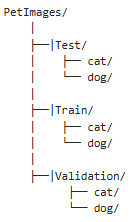

Einlesen der Bibliotheken

In [59]:
from PIL import Image # Modul zum Laden von Bildern aus Dateien
from tensorflow import keras # API in TensorFlow für Aufbau und Training von Modellen
import tensorflow as tf  # Laden von TensorFlow 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os # Zugriff auf Funktionen des Betriebssystems

In [10]:
# Setzen eines Seeds für die Reproduzierbarkeit innerhalb des Jupyter Notebooks
tf.random.set_seed(123)
np.random.seed(123)

In [13]:
# Pfade zum Ordner mit Cat und Dog
train_path = "PetImages/Train"
test_path = "PetImages/Test"
val_path = "PetImages/Validation"
#----------------------------------------------------
# 
def convert_images_to_rgb_and_resize(folder, target_size=(180, 180)):
    for subdir, _, files in os.walk(folder): # durchläuft rekursiv alle Unterordner und Dateien
        for file in files:
            filepath = os.path.join(subdir, file) # Kombiniert den Pfad des Unterordners und Dateinamen für genauen Pfad
            try:
                with Image.open(filepath) as img: # Öffnet Bild im Pfad                    
                    img_array = np.array(img) # Überprüfe auf Kanäle [Höhe, Breite,Anzahl Kanäle]
                    if len(img_array.shape) == 2 or img_array.shape[2] == 2: # Wenn 1 Kanal oder 2 Kanäle vorhanden sind, in RBG umwandeln
                        img = img.convert("RGB")  # In RGB umwandeln
                    img = img.resize(target_size)  # Bilder auf die Zielgröße anpassen (180x180)
                    img.save(filepath) # Speichern im gleichen Verzeichnis und Dateinamen. Dadruch wird das bild ersetzt.
                    
            except Exception as e: # Wenn ein Fehler auftritt (öffnen, bearbeitenm speichern etc.)
                try:
                    os.remove(filepath)  # Dann löschen
                except:
                    pass   

# Einmal auf alle Ordner anwenden
convert_images_to_rgb_and_resize(train_path)
convert_images_to_rgb_and_resize(val_path)
convert_images_to_rgb_and_resize(test_path)
#------------------------------------------------------
# Batch und Bildformat definieren
batch_size = 32
img_height = 180
img_width = 180
#------------------------------------------------------

# Autotune importieren, damit Daten vorbereitet werden während das Modell rechnet
AUTOTUNE = tf.data.AUTOTUNE 

# Datensätze für Train, Val und Test definieren
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb' # Optinal: Zusätzliches erwingen von RGB
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

# Klassenname abspeichern
train_names = train_ds.class_names
val_names = val_ds.class_names
test_names = test_ds.class_names

# Daten speichern im RAM -> Datensatz mischen -> Batches im Hintergrund laden, während aktueller Verarbeitung
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Für Validierung und Test: Daten speichern im RAM -> -> Batches im Hintergrund laden, während aktueller Verarbeitun
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 19948 files belonging to 2 classes.
Found 2495 files belonging to 2 classes.
Found 2494 files belonging to 2 classes.


Die Datensätze wurden in **Train, Validation und Test** eingeteilt.\
Die im Unterordner liegenen Daten sind im Verhältnis (80,10,10) %.

In [14]:
print(train_names, train_names, train_names)

['cat', 'dog'] ['cat', 'dog'] ['cat', 'dog']


Ein weiterer **Vorteil**:\
Durch die *image_dataset_from_directory-Methode* kann TensorFlow automatisch die Label-Zuordnung basierend auf den Ordnernamen vornehmen.\
Somit hat jeder Unterordner die Klassifizierung **"cat"** und **"dog"**.

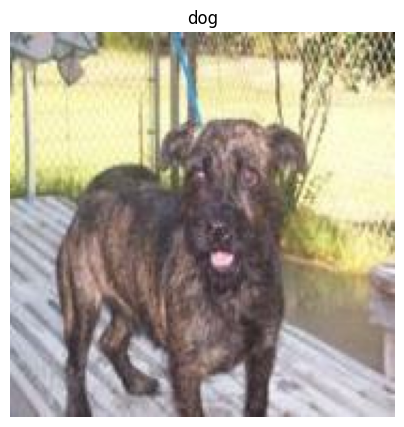

In [15]:
# Ein Batch manuell entnehmen
for images, labels in train_ds.take(1):
    images_batch = images
    labels_batch = labels

# Ein zufälliges Bild entnehmen
plt.figure(figsize=(5, 5)) # figure größe
plt.imshow(images_batch[0].numpy().astype("uint8")) # Datentyp anpassen für korrekte Anzeige 
plt.title(train_names[int(labels_batch[0])]) # Anzeigen des Bildes mit der entsprechenden Klassenbezeichnung
plt.axis("off") # ausblendung der X und Y-Werte der Achsen
plt.show();

### Modellierung

**Idee**: Ein klassischer Aufbau für **CNN** (Convolutional Neural Networks)\
Die ersten Layer lernen einfache Muster und spätere werden komplexere Kombinationen davon erstellt.

*Modell erstellen:*

In [16]:
from tensorflow.keras import layers # Schicht-Methode

model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Pixelbereich [0, 255] auf [0 und 1 bringen]
    layers.Conv2D(32, 3, activation='relu'), # Faltungsschicht die Kanten und Texturen erkennt. Mit ReLU-Aktivierung die neg. Werte auf 0 setzt.
    layers.MaxPooling2D(), # Downsampling Methode um wichtigste Features zu erhalten, was Rechenaufwand reduziert.
    layers.Conv2D(64, 3, activation='relu'), # Muster werden wiederholt um komplexere Merkmale zu erkennen.
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(), # Wandelt 2D feature Maps in ein 1D Vektor, welcher der Input für den Dense layer wird.
    layers.Dense(128, activation='relu'), # Ein Layer mit 128 Neuronen und der ReLU-Aktivierung.
    layers.Dense(1, activation='sigmoid')  
    # Ein letzter Layer (Ausgang) mit einem Neuron und der Sigmoidfunktion (Wertebereich zwischen 0 und 1, ideal für Klassifikation)
])

*Modell kompilieren:*

In [17]:
model.compile(
    optimizer='adam',  # Adaptive Moment Estimation, weil es schnell und effizient ist
    loss='binary_crossentropy',  # Typisch für binäre Klassifikation
    metrics=['accuracy'] # misst, wie oft das Modell richtig liegt
)

*Modell trainieren:*\
Da die Datensätze in Training, Validierung und Test unterteilt sind, werden die Trainingsdaten trainiert und erstmal durch die Validierung bestimmt.\
Somit wird geprüft, wie das Modell auf Daten funktioniert, die s noch nicht gesehen hat.

In [18]:
epochs = 10 # 10 Wiederholungen 

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.6036 - loss: 0.6684 - val_accuracy: 0.7587 - val_loss: 0.5206
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.7650 - loss: 0.4914 - val_accuracy: 0.7964 - val_loss: 0.4440
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.8328 - loss: 0.3737 - val_accuracy: 0.8116 - val_loss: 0.4391
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.8843 - loss: 0.2731 - val_accuracy: 0.8244 - val_loss: 0.4171
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.9316 - loss: 0.1627 - val_accuracy: 0.8040 - val_loss: 0.6018
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.9699 - loss: 0.0818 - val_accuracy: 0.8240 - val_loss: 0.6899
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.9878 - loss: 0.0385 - val_accuracy: 0.8008 - val_loss: 0.9219
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9868 - loss: 0

Die Genauigkeit der Trainingsdaten lag bei **99 %** und auf den Validierungsdaten bei **80.5 %.**

Schauen wir uns nun den Score auf den Testdatensatz an, was das Modell noch nicht gesehen hat.

In [19]:
# Testen des Modells auf den Testdaten
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Score: {:.4f}".format(test_accuracy))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8110 - loss: 0.9951
Test Loss: 1.0059
Test Score: 0.8091


Die Genauigkeit auf die Testdaten liegen hier bei **80.9 %** was für den Anfang nicht schlecht ist.\
Dennoch erkennt man ein **Overfitting**, weil die Vali/Test Accuracy schlechter ist in Bezug auf Train.\
Außerdem ist die **Validation Loss sehr hoch**, was mehr Unsicherheit bei neuen Daten bringt.

Die Frage ist nun wie man die Performance steigern kann.

## Ablation Study 
***(Kontrollierter Vergleich)***

Es soll nun verglichen werden, ob die Veränderung einiger Parameter zum gewünschten Erfolg führt.

Ansatz: **Datenaugmentierungen**\
Beim Augmentieren der Trainingsdaten erhofft man sich eine bessere Verallgemeinerung des Modells.

In [20]:
# Erstellung einer Augmentierung
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # horizontal flippen (spiegeln).
    layers.RandomRotation(0.1),       # ca. 10% rotieren.
    layers.RandomZoom(0.1),           # leicht Zoom (rein/raus).
    layers.RandomContrast(0.1),       # Kontrast anpassen.
    layers.RandomTranslation(0.1, 0.1)  # Verschiebung in x- und y-Richtung.
])

# Das selbe Modell nochmal nutzen mit dem Unterschied vorher die Augmentation einzubinden.
model = tf.keras.Sequential([

    data_augmentation, # Augmentation hinzufügen.
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Pixelbereich [0, 255] auf [0 und 1 bringen].
    layers.Conv2D(32, 3, activation='relu'), # Faltungsschicht die Kanten und Texturen erkennt. Mit ReLU-Aktivierung die neg. Werte auf 0 setzt.
    layers.MaxPooling2D(), # Downsampling Methode um wichtigste Features zu erhalten, was Rechenaufwand reduziert.
    layers.Conv2D(64, 3, activation='relu'), # Muster werden wiederholt um komplexere Merkmale zu erkennen.
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(), # Wandelt 2D feature Maps in ein 1D Vektor, welcher der Input für den Dense layer wird.
    layers.Dense(128, activation='relu'), # Ein Layer mit 128 Neuronen und der ReLU-Aktivierung.
    layers.Dense(1, activation='sigmoid')  
    # Ein letzter Layer (Ausgang) mit einem Neuron und der Sigmoidfunktion (Wertebereich zwischen 0 und 1, ideal für Klassifikation).
])

model.compile(
    optimizer='adam',  # Adaptive Moment Estimation, weil es schnell und effizient ist.
    loss='binary_crossentropy',  # Typisch für binäre Klassifikation.
    metrics=['accuracy'] # Misst, wie oft das Modell richtig liegt.
)

In [21]:
epochs = 10 # 10 Wiederholungen 

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - accuracy: 0.5630 - loss: 0.6966 - val_accuracy: 0.6505 - val_loss: 0.6196
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.6755 - loss: 0.6058 - val_accuracy: 0.7475 - val_loss: 0.5268
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.7315 - loss: 0.5439 - val_accuracy: 0.7643 - val_loss: 0.4780
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.7487 - loss: 0.5076 - val_accuracy: 0.8028 - val_loss: 0.4342
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.7632 - loss: 0.4886 - val_accuracy: 0.8116 - val_loss: 0.4183
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.7843 - loss: 0.4540 - val_accuracy: 0.7956 - val_loss: 0.4218
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.7971 - loss: 0.4377 - val_accuracy: 0.8261 - val_loss: 0.3962
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.8101 - loss: 0

In [22]:
# Testen des Modells auf den Testdaten
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Score: {:.4f}".format(test_accuracy))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8242 - loss: 0.3889
Test Loss: 0.3810
Test Score: 0.8260


Zwar haben wir in Bezug auf die Trainingsdaten  eine geringere Genauigkeit aber das Modell **generalisiert viel besser** (Accuracy bei allen fast gleich).\
Der **Testscore** ist hier auch **höher** als vorher.

Im nächsten Schritt wird untersucht, ob eine Erhöhung der Epoche zu einer Verbesserung des Modells führt, da dem Modell mehr Zeit zum Trainieren zur Verfügung steht.\
Zu diesem Zweck wird ***epochs*** auf **20** gesetzt.

In [23]:
epochs = 20 

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.8386 - loss: 0.3606 - val_accuracy: 0.8605 - val_loss: 0.3238
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 124ms/step - accuracy: 0.8418 - loss: 0.3548 - val_accuracy: 0.8529 - val_loss: 0.3301
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.8490 - loss: 0.3470 - val_accuracy: 0.8581 - val_loss: 0.3145
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.8512 - loss: 0.3330 - val_accuracy: 0.8749 - val_loss: 0.2843
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.8558 - loss: 0.3287 - val_accuracy: 0.8461 - val_loss: 0.3530
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.8638 - loss: 0.3111 - val_accuracy: 0.8589 - val_loss: 0.3256
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.8623 - loss: 0.3184 - val_accuracy: 0.8786 - val_loss: 0.2804
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 77s 124ms/step - accuracy: 0.8670 - loss: 0

In [24]:
# Testen des Modells auf den Testdaten
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Score: {:.4f}".format(test_accuracy))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8664 - loss: 0.3261
Test Loss: 0.3081
Test Score: 0.8733


## Ergebnisse

Die Erhöhung der Epoche hat gezeigt, dass die Performance nochmal deutlich angestiegen ist.\
Im Detail:
* Training und Validation sind sehr nah beieinander **(89,38 % zu 89,86 %)**
* Test Accuracy ist ebenso hoch -> Modell generalisiert gut auf neue Daten **(87,33 %)**
* Performance und Robustheit deutlich besserer als zuvor.

Als Beispiel werden hier einige Bilder aus dem Testdatensatz an das Modell übergeben, um die Vorhersagen zu überprüfen.

In [52]:
y_pred = model.predict(test_ds) # Vorhersage machen aus Testdaten
y_pred_classes = (y_pred > 0.5).astype("int32") # Klasse kategorisieren (0 = Katze, 1 = Hund. Ab 0.5 und größer = Hund)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


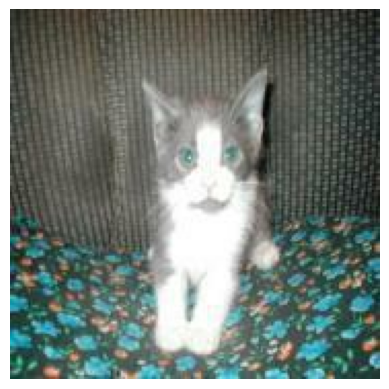

Katze=0, Hund=1
Echtes Label: 0
Vorhersage: 0
Wahrscheinlichkeit der Vorhersage: 0.0246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


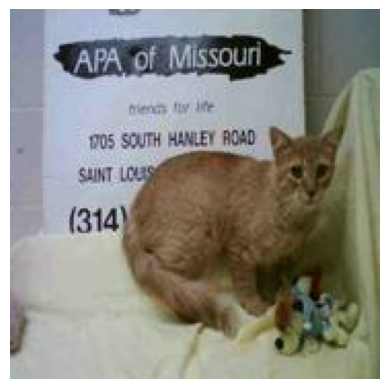

Katze=0, Hund=1
Echtes Label: 0
Vorhersage: 0
Wahrscheinlichkeit der Vorhersage: 0.0475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


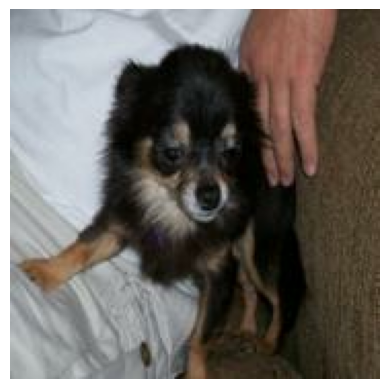

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.9820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


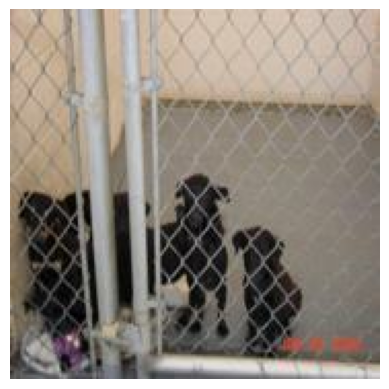

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 0
Wahrscheinlichkeit der Vorhersage: 0.4231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


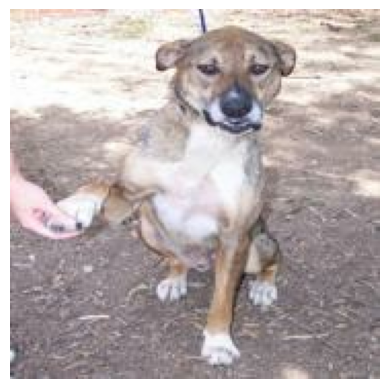

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.9997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


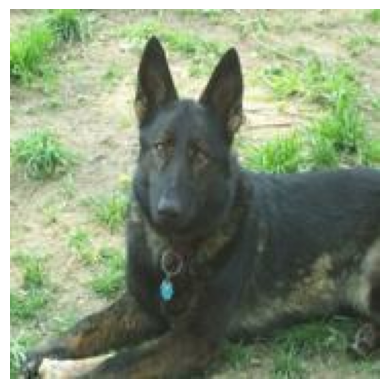

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.9324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


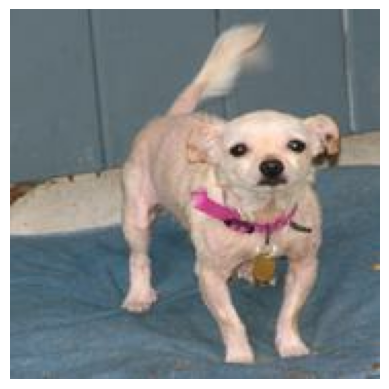

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.9996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


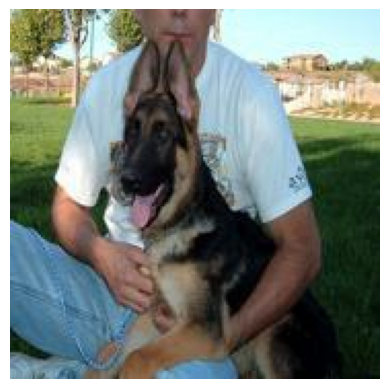

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


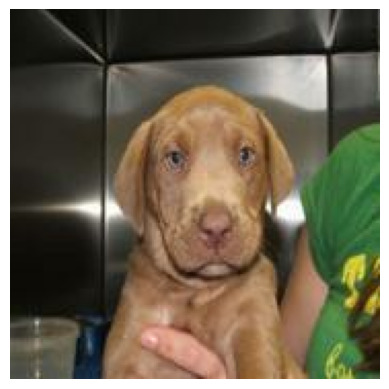

Katze=0, Hund=1
Echtes Label: 1
Vorhersage: 1
Wahrscheinlichkeit der Vorhersage: 0.9750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


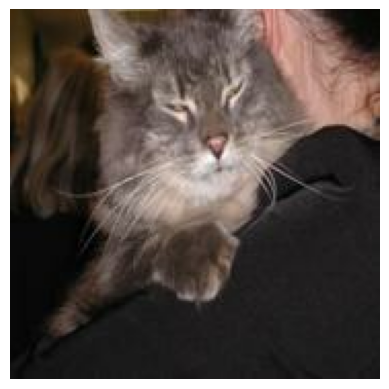

Katze=0, Hund=1
Echtes Label: 0
Vorhersage: 0
Wahrscheinlichkeit der Vorhersage: 0.0011


In [58]:
for images, labels in test_ds.take(10):  # 10 Bilder aus einen Batch vom Testdatensatz
    i=30 # Beispiel aus Batch Index 30
    
    image = images[i] # Indexübergabe
    label = labels[i]
   
    image = np.expand_dims(image, axis=0)  # Das Bild in einen Batch von Größe 1 umwandeln: (180, 180, 3) → (1, 180, 180, 3)
    y_pred = model.predict(image)  # Vorhersage für das Bild
    y_pred_class = (y_pred > 0.5).astype("int32")  # Vorhersage in Klassen umwandeln (0 oder 1)

    plt.imshow(images[i].numpy().astype("uint8"))  # Das Bild anzeigen
    plt.axis('off')  # Achsen ausblenden
    plt.show()

    print("Katze=0, Hund=1")
    print("Echtes Label: {}".format(label.numpy())) # Wahres Label
    print("Vorhersage: {}".format(y_pred_class[0][0])) # Vorhergesagte Klasse
    print("Wahrscheinlichkeit der Vorhersage: {:.4f}".format(y_pred[0][0])) # Wahrscheinlichkeit
    

Die Vorhersagen waren schon recht gut, nur beim 4.Bild war sich das Modell nicht ganz sicher.\
Mögliche Gründe:
* Bild etwas unscharf.
* Die Hunde waren alle komplett schwarz -> Umrisse und Details schwer zu erkennen.
* Die Hunde waren hinter einem Zaun, was die Auswertung zusätzlich erschwert.
Dennoch war ***y_predict*** hier bei "0.423" also knapp an den "0.5" für die Klassifizierung als **Hund**.